Analysis of Gridded Ensemble Precipitation and Temperature Estimates over the Contiguous United States
====

For this example, we'll open a 9 members of a 100 member ensemble of precipitation and temperature data. The analysis we do below is quite simple but the problem is a good illustration of an IO bound task. 

Link to dataset: https://www.earthsystemgrid.org/dataset/gridded_precip_and_temp.html

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client, progress

### Connect to Dask Distributed Cluster

In [2]:
pangeo = 'WHOI-HPC-POSEIDON'

In [3]:
if pangeo=='PANGEO-GCE':
    
    import gcsfs
    
    ### Load with FUSE File system
    # ds = xr.open_mfdataset('/gcs/newmann-met-ensemble-netcdf/conus_ens_00*.nc',
    #                        engine='netcdf4', concat_dim='ensemble', chunks={'time': 50})

    fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
    zarr_ds = gcsfs.mapping.GCSMap('pangeo-data/newman-met-ensemble',
                                      gcs=fs, check=False, create=False)

    from dask_kubernetes import KubeCluster
    cluster = KubeCluster(n_workers=10)
    cluster

In [4]:
if pangeo=='WHOI-HPC-POSEIDON':
    
    zarr_ds = '/home/usgs/rsignell/data/newmann-zarr/conus_ens'
    

    
    from dask_jobqueue import SLURMCluster
    import os
#    cluster = SLURMCluster(processes=36, threads=1, memory='5GB', 
#                       project='science', walltime='01:00:00', queue='compute')
    cluster = SLURMCluster(processes=36, threads=1, memory='5GB', 
                        walltime='01:00:00', queue='compute')
    workers = cluster.start_workers(2)
    print(cluster.job_script())

#!/bin/bash

#SBATCH -J dask-worker
#SBATCH -e dask-worker.err
#SBATCH -o dask-worker.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=168G
#SBATCH -t 01:00:00



/vortexfs1/usgs/rsignell/miniconda3/envs/pangeo/bin/dask-worker tcp://10.141.0.11:34915 --nthreads 1 --nprocs 36 --memory-limit 5GB --name dask-worker-4 --death-timeout 60



In [5]:
cluster

In [6]:
client = Client(cluster)

### Open Dataset

Here we try loading a traditional atmospheric dataset using:
1. local netcdf format files on a traditional file system.
2. [Zarr](http://zarr.readthedocs.io/en/stable/), a new format for storing ndarray data, using the NetCDF data model 

The dataset has dimensions of time, latitude, longitude, and ensmemble member. Each format is self-describing.

In [7]:
%%time
#ds = xr.open_zarr(zarr_ds)
ds = xr.open_mfdataset('/vortexfs1/usgs/rsignell/data/newmann-netcdf/conus_ens_0*',
                      engine='netcdf4', concat_dim='ensemble', chunks={'time': 50})
ds = ds.isel(ensemble=range(0,98,11))


### Load with intake catalog service
# import intake
# cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo/master/gce/catalog.yaml')
# ds = cat.newmann_zarr.read_chunked()

CPU times: user 4.31 s, sys: 312 ms, total: 4.63 s
Wall time: 21.5 s


In [8]:
# Print dataset
ds

<xarray.Dataset>
Dimensions:    (ensemble: 9, lat: 224, lon: 464, time: 12054)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
  * lon        (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 ...
  * lat        (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...
Dimensions without coordinates: ensemble
Data variables:
    elevation  (ensemble, lat, lon) float64 dask.array<shape=(9, 224, 464), chunksize=(1, 224, 464)>
    pcp        (ensemble, time, lat, lon) float64 dask.array<shape=(9, 12054, 224, 464), chunksize=(1, 50, 224, 464)>
    t_mean     (ensemble, time, lat, lon) float64 dask.array<shape=(9, 12054, 224, 464), chunksize=(1, 50, 224, 464)>
    t_range    (ensemble, time, lat, lon) float64 dask.array<shape=(9, 12054, 224, 464), chunksize=(1, 50, 224, 464)>
    mask       (ensemble, lat, lon) int32 dask.array<shape=(9, 224, 464), chunksize=(1, 224, 464)>
    t_max      (ensemble, time, lat, lon) float64 dask.array<shape=

### Figure: Elevation and domain mask

A quick plot of the mask to give us an idea of our spatial domain

Text(0.5,1,'Domain Elevation')

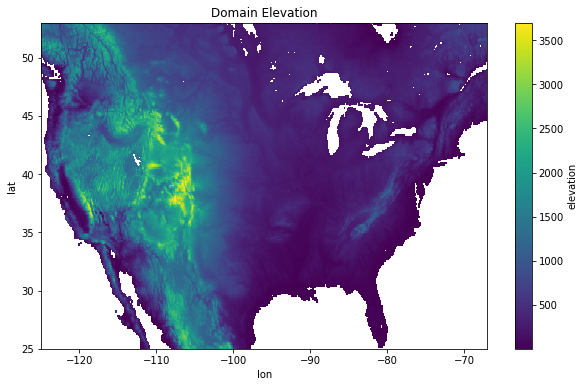

In [9]:
elevation = ds['elevation'].isel(ensemble=0).persist()
elevation = elevation.where(elevation > 0)
elevation.plot(figsize=(10, 6))
plt.title('Domain Elevation')

### Intra-ensemble range

We calculate the intra-ensemble range for all the mean daily temperature in this dataset.  This gives us a sense of uncertainty.

In [10]:
ds['t_mean'].nbytes/1e9

90.204807168

In [11]:
temp_mean = ds['t_mean'].mean(dim='time')
spread = (temp_mean.max(dim='ensemble')
        - temp_mean.min(dim='ensemble'))
spread

<xarray.DataArray 't_mean' (lat: 224, lon: 464)>
dask.array<shape=(224, 464), dtype=float64, chunksize=(224, 464)>
Coordinates:
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 -124.2 ...
  * lat      (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...

### Calling compute
The expressions above didn't actually compute anything. They just build the task graph. To do the computations, we call the `compute` or `persist` methods:

In [12]:
spread = spread.persist()
progress(spread)

VBox()

#### Figure: Intra-ensemble range


In [13]:
import hvplot.xarray

In [15]:
spread.hvplot(rasterize=True)

:DynamicMap   []
   :Image   [lat,lon]   (t_mean)

In [ ]:
spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

### Average seasonal snowfall

We can compute a crude estimate of average seasonal snowfall using the temperature and precipitation variables in our dataset. Here, we'll look at the first 4 ensemble members and make some maps of the seasonal total snowfall in each ensemble member.

In [ ]:
da_snow = ds['pcp'].where(ds['t_mean'] < 0.).resample(time='QS-Mar').sum('time')
seasonal_snow = da_snow.isel(ensemble=slice(0, 4)).groupby('time.season').mean('time').persist()
progress(seasonal_snow)

In [ ]:
# properly sort the seasons
seasonal_snow = seasonal_snow.sel(season=['DJF', 'MAM','JJA', 'SON'])

#### Figure: Average seasonal snowfall totals 

In [ ]:
# units here are in mm/season
seasonal_snow.plot.pcolormesh(col='season', row='ensemble', cmap='Blues', robust=True)

### Extract a time series of annual maximum precipitation events over a region

In the previous two examples, we've mostly reduced the time and/or ensemble dimension. Here, we'll do a reduction operation on the spatial dimension to look at a time series of extreme precipitation events on Cape Cod, MA

In [ ]:
buf = 0.25  # look at Otis, Cape Cod, MA 41.65 -70.52 +/- 0.25 deg
slat = 41.65
slon = -70.52

ds_tx = ds.sel(lon=slice(slon-buf, slon+buf), lat=slice(slat-buf, slat+buf))

In [ ]:
pcp_ann_max = ds_tx['pcp'].resample(time='AS').max('time')

In [ ]:
pcp_ann_max_ts = pcp_ann_max.max(('lat', 'lon')).persist()
progress(pcp_ann_max_ts)

#### Figure: Timeseries of maximum precipitation near Station

In [ ]:
ax = pcp_ann_max_ts.transpose().to_pandas().plot(title='Maximum precipitation on Cape Cod')

In [ ]:
cluster.stop_workers(workers)